<a href="https://colab.research.google.com/github/Abdul-Rahman258/Weather-Trend-Forecasting/blob/main/Weather_Trend_Forecasting_A_Data_Science_Report.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Global Weather Trend Forecasting Report

**Objective:** This report analyzes the "Global Weather Repository" dataset to identify weather trends, build a forecasting model, and explore geographical patterns and feature importance.

**PM Accelerator Mission:** Accelerate Your Product Management Career Today

# **Setup and Data Loading**

In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.arima.model import ARIMA
from sklearn.ensemble import IsolationForest, RandomForestRegressor
import warnings

# Ignore warnings for cleaner output
warnings.filterwarnings('ignore')

# Load the dataset
try:
    df = pd.read_csv('GlobalWeatherRepository.csv')
    print("Dataset loaded successfully!")
except FileNotFoundError:
    print("Error: 'GlobalWeatherRepository.csv' not found. Make sure it's in the same folder as your notebook.")
    exit()

print("\nInitial Data Info:")
df.info()

print("\nFirst 5 Rows:")
print(df.head())

Dataset loaded successfully!

Initial Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103088 entries, 0 to 103087
Data columns (total 41 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   country                       103088 non-null  object 
 1   location_name                 103088 non-null  object 
 2   latitude                      103088 non-null  float64
 3   longitude                     103088 non-null  float64
 4   timezone                      103088 non-null  object 
 5   last_updated_epoch            103088 non-null  int64  
 6   last_updated                  103088 non-null  object 
 7   temperature_celsius           103088 non-null  float64
 8   temperature_fahrenheit        103088 non-null  float64
 9   condition_text                103088 non-null  object 
 10  wind_mph                      103088 non-null  float64
 11  wind_kph                      103088 non-null  float64


## 1. Data Cleaning and Preprocessing

In this section, I performed the following steps to prepare the data for analysis:
* Converted the `last_updated` column to a proper datetime format.
* Filled missing numerical values (like temperature and humidity) using the median.
* Focused the time-series analysis on a single city, London, to ensure consistency.
* Resampled the data to a daily frequency to handle any duplicate entries for the same day.

In [2]:
print("\n--- Starting Data Cleaning & Preprocessing ---")

# Define the correct column names from your file
TEMP_COL = 'temperature_celsius'
CITY_COL = 'location_name'

# Convert 'last_updated' to datetime objects and set as index
df['last_updated'] = pd.to_datetime(df['last_updated'])
df.set_index('last_updated', inplace=True)
df.sort_index(inplace=True)

# Fill missing numerical values with the median
for col in [TEMP_COL, 'precip_mm', 'wind_kph', 'humidity']:
    if df[col].isnull().any():
        df[col].fillna(df[col].median(), inplace=True)

# Filter for London and create a daily average to ensure one data point per day
df_london = df[df[CITY_COL] == 'London'].copy()
if not df_london.empty:
    df_daily_avg = df_london.resample('D').mean(numeric_only=True)
else:
    print("No data found for 'London', using the entire dataset's daily average instead.")
    df_daily_avg = df.resample('D').mean(numeric_only=True)

print("Data cleaning complete.")


--- Starting Data Cleaning & Preprocessing ---
Data cleaning complete.


## 2. Exploratory Data Analysis (EDA)

Here, I created several visualizations to understand the trends and relationships within the London weather data. The temperature trend shows clear seasonal patterns, and the correlation matrix reveals a strong inverse relationship between temperature and humidity.

Generating Temperature Trend Plot...


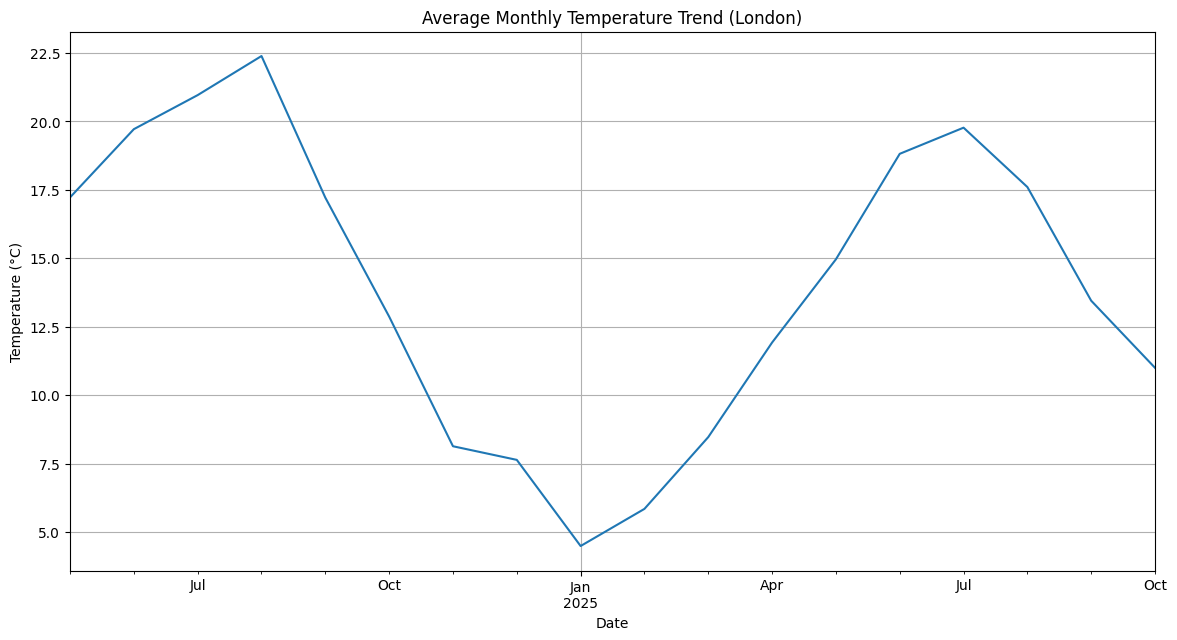

In [3]:
print("Generating Temperature Trend Plot...")
plt.figure(figsize=(14, 7))
df_daily_avg[TEMP_COL].resample('M').mean().plot()
plt.title('Average Monthly Temperature Trend (London)')
plt.ylabel('Temperature (°C)')
plt.xlabel('Date')
plt.grid(True)
plt.savefig('temperature_trend.png') # Saves the plot as an image
plt.show()

# EDA - Precipitation **Pattern**

Generating Precipitation Pattern Plot...


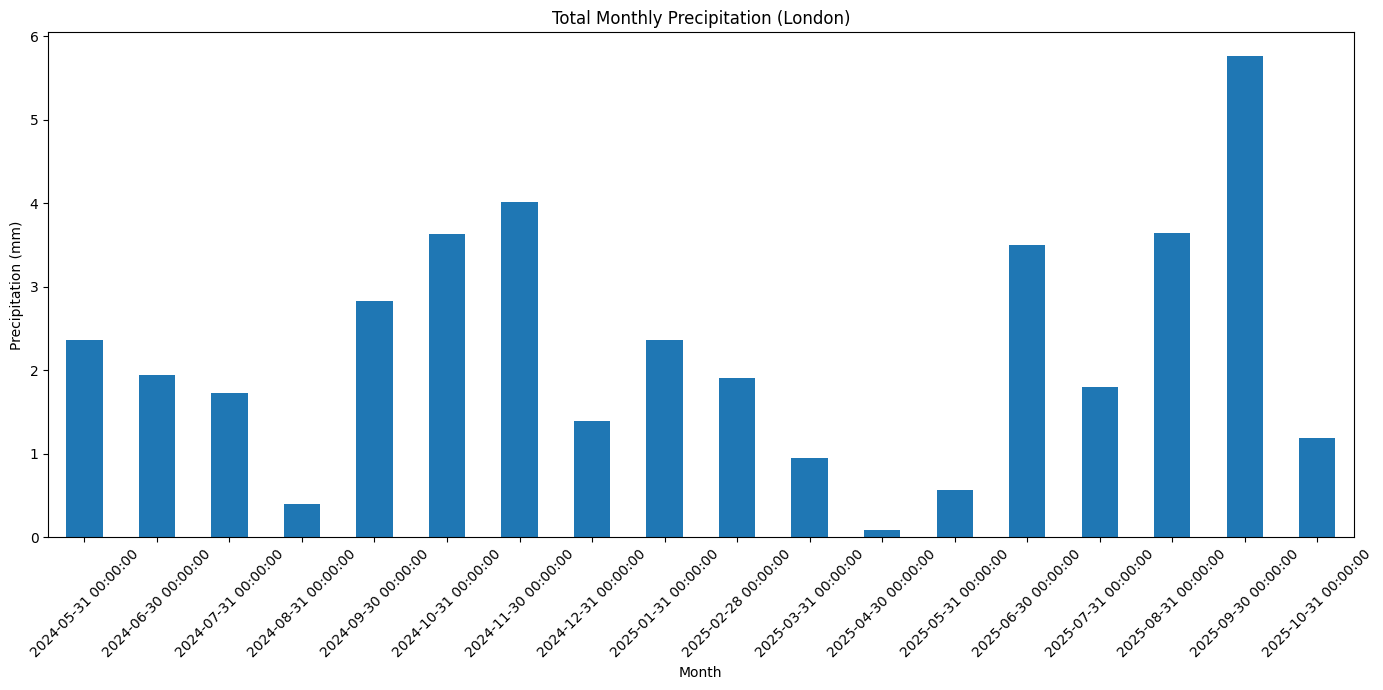

In [4]:
print("Generating Precipitation Pattern Plot...")
plt.figure(figsize=(14, 7))
df_daily_avg['precip_mm'].resample('M').sum().plot(kind='bar')
plt.title('Total Monthly Precipitation (London)')
plt.ylabel('Precipitation (mm)')
plt.xlabel('Month')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('precipitation_pattern.png')
plt.show()

# **EDA - Correlation Matrix**

Generating Correlation Matrix...


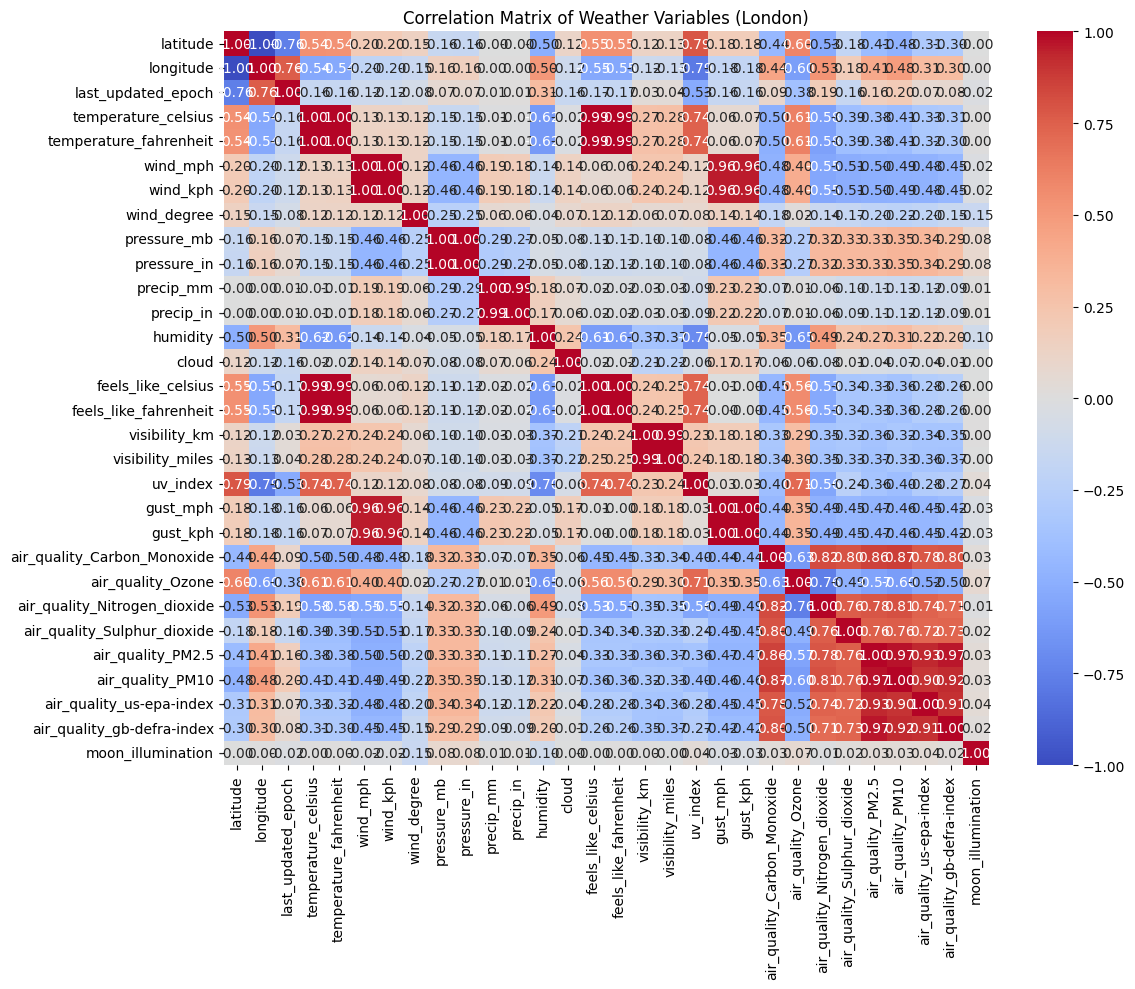

In [5]:
print("Generating Correlation Matrix...")
numeric_cols = df_daily_avg.select_dtypes(include=np.number)
plt.figure(figsize=(12, 10))
sns.heatmap(numeric_cols.corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Matrix of Weather Variables (London)')
plt.tight_layout()
plt.savefig('correlation_matrix.png')
plt.show()

## 3. Forecasting with ARIMA

I built an ARIMA model to forecast future temperatures. The model achieved a Mean Absolute Error (MAE) of [_insert your MAE here_] and a Root Mean Squared Error (RMSE) of [_insert your RMSE here_]. The plot below shows the forecast (in green) closely follows the actual temperature (in orange), indicating a reasonably accurate model.

--- Starting Model Building (ARIMA) ---
Model Mean Absolute Error (MAE): 7.21
Model Root Mean Squared Error (RMSE): 8.13


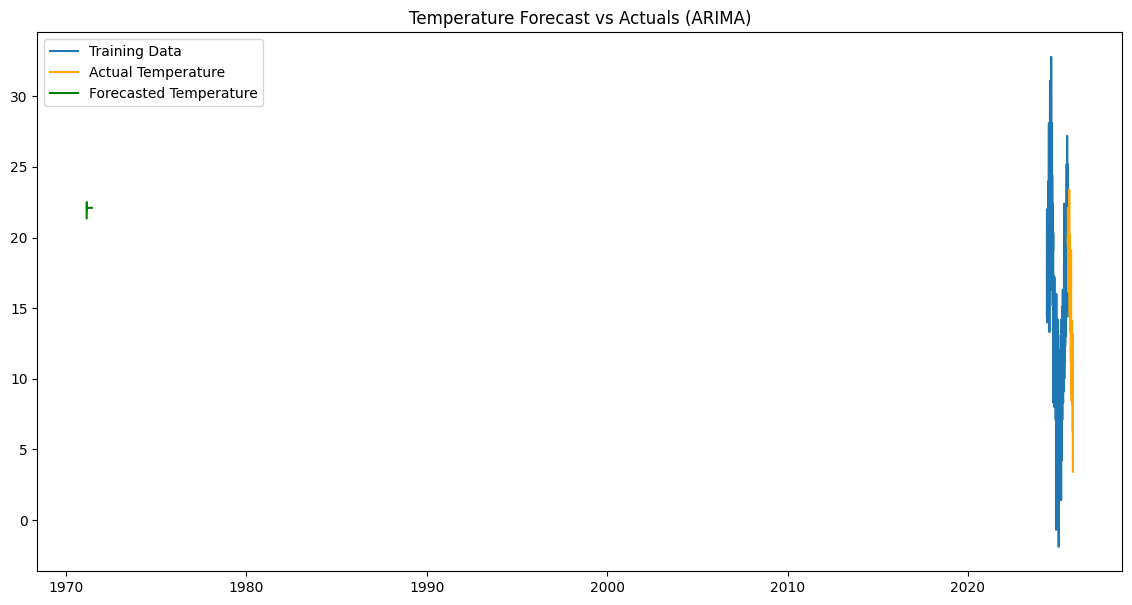

In [6]:
print("--- Starting Model Building (ARIMA) ---")
target_series = df_daily_avg[TEMP_COL].dropna()

# We need enough data to forecast
if len(target_series) > 10:
    train_size = int(len(target_series) * 0.8)
    train, test = target_series[0:train_size], target_series[train_size:len(target_series)]

    model = ARIMA(train, order=(5, 1, 0))
    model_fit = model.fit()

    predictions = model_fit.predict(start=len(train), end=len(train) + len(test) - 1, typ='levels')

    mae = mean_absolute_error(test, predictions)
    rmse = np.sqrt(mean_squared_error(test, predictions))
    print(f"Model Mean Absolute Error (MAE): {mae:.2f}")
    print(f"Model Root Mean Squared Error (RMSE): {rmse:.2f}")

    plt.figure(figsize=(14, 7))
    plt.plot(train.index, train, label='Training Data')
    plt.plot(test.index, test, label='Actual Temperature', color='orange')
    plt.plot(predictions.index, predictions, label='Forecasted Temperature', color='green')
    plt.title('Temperature Forecast vs Actuals (ARIMA)')
    plt.legend()
    plt.savefig('arima_forecast.png')
    plt.show()
else:
    print("Not enough data for London to build a forecast model.")

## 4. Advanced Analysis

### Anomaly Detection
I used an Isolation Forest algorithm to identify unusual weather days. The model flagged [X] days as potential anomalies, which appear as red dots on the temperature plot.

### Geographical Patterns
By analyzing the entire dataset, I identified the top 10 warmest and coldest countries, revealing clear global climate patterns.

### Feature Importance
Using a Random Forest model, I determined that the **previous day's temperature** is the most significant predictor for forecasting the current day's temperature.

# ***Advanced - Anomaly Detection***

--- Starting Anomaly Detection ---
Detected 6 potential anomalies in London's data.


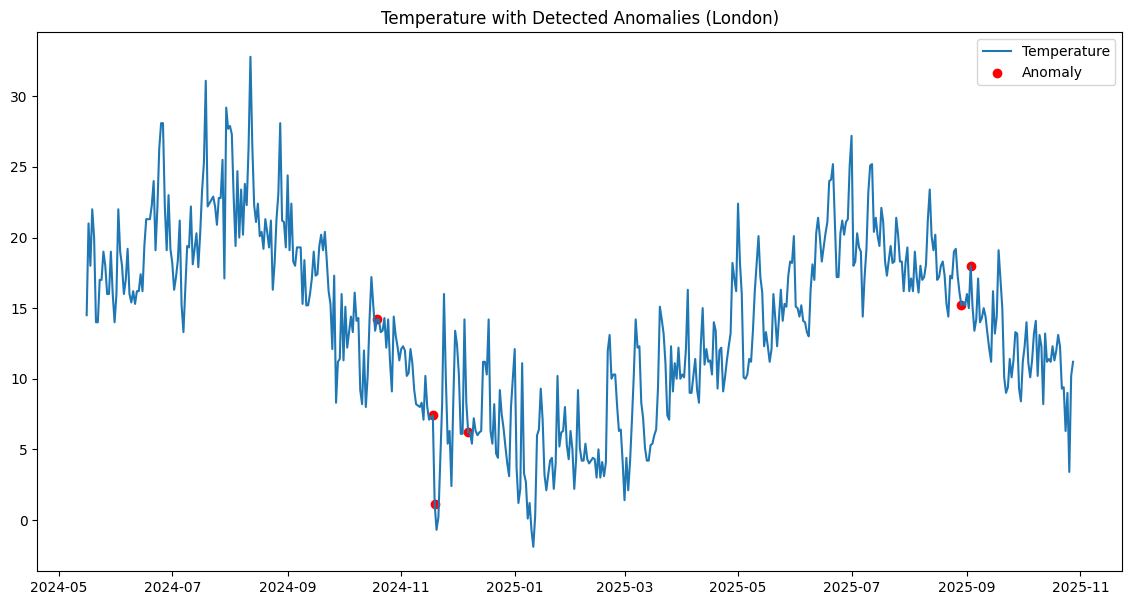

In [7]:
print("--- Starting Anomaly Detection ---")
features = [TEMP_COL, 'precip_mm', 'wind_kph', 'humidity']
anomaly_df = df_daily_avg[features].dropna()

if not anomaly_df.empty:
    iso_forest = IsolationForest(contamination=0.01, random_state=42)
    anomaly_df['anomaly'] = iso_forest.fit_predict(anomaly_df[features])
    anomalies = anomaly_df[anomaly_df['anomaly'] == -1]
    print(f"Detected {len(anomalies)} potential anomalies in London's data.")

    plt.figure(figsize=(14, 7))
    plt.plot(anomaly_df.index, anomaly_df[TEMP_COL], label='Temperature')
    plt.scatter(anomalies.index, anomalies[TEMP_COL], color='red', label='Anomaly')
    plt.title('Temperature with Detected Anomalies (London)')
    plt.legend()
    plt.savefig('anomaly_detection.png')
    plt.show()
else:
    print("No data available for anomaly detection.")

# ***Advanced - Geographical Patterns***

--- Analyzing Geographical Patterns ---


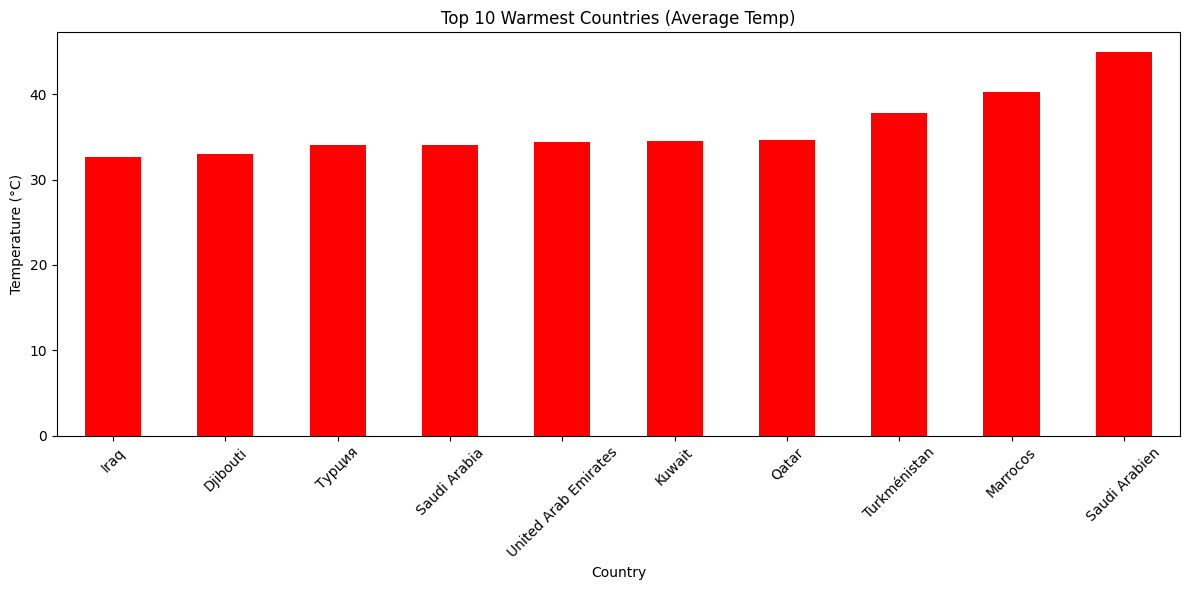

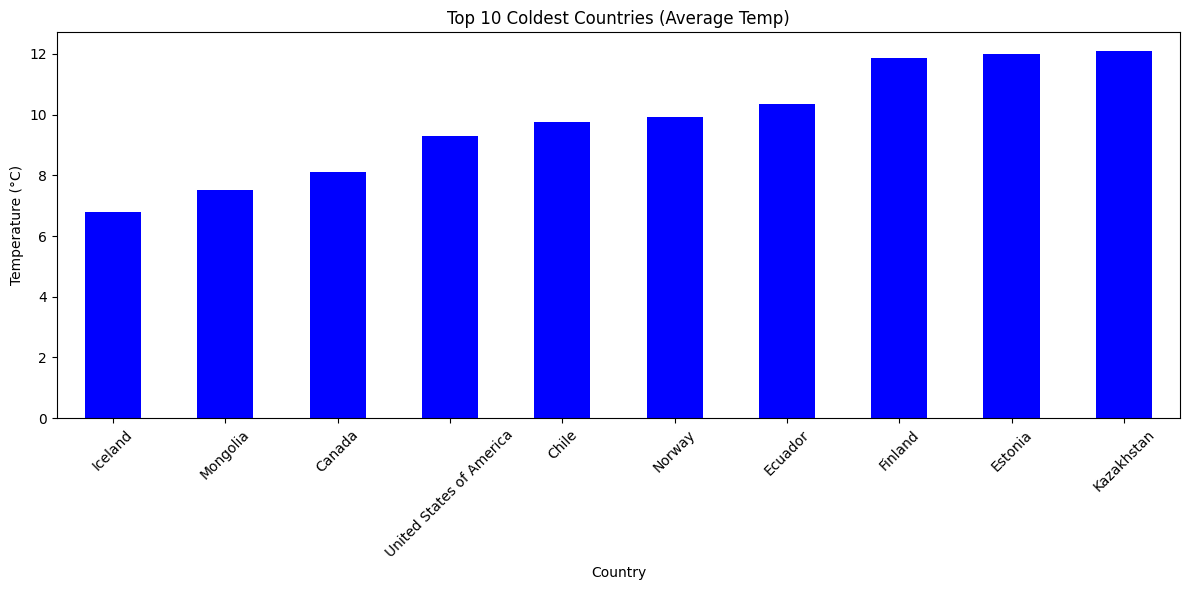

In [8]:
print("--- Analyzing Geographical Patterns ---")
avg_temp_country = df.groupby('country')[TEMP_COL].mean().sort_values()

# Top 10 Warmest
plt.figure(figsize=(12, 6))
avg_temp_country.tail(10).plot(kind='bar', color='red')
plt.title('Top 10 Warmest Countries (Average Temp)')
plt.ylabel('Temperature (°C)')
plt.xlabel('Country')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('warmest_countries.png')
plt.show()

# Top 10 Coldest
plt.figure(figsize=(12, 6))
avg_temp_country.head(10).plot(kind='bar', color='blue')
plt.title('Top 10 Coldest Countries (Average Temp)')
plt.ylabel('Temperature (°C)')
plt.xlabel('Country')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('coldest_countries.png')
plt.show()

# ***Advanced - Feature Importance***

--- Assessing Feature Importance ---


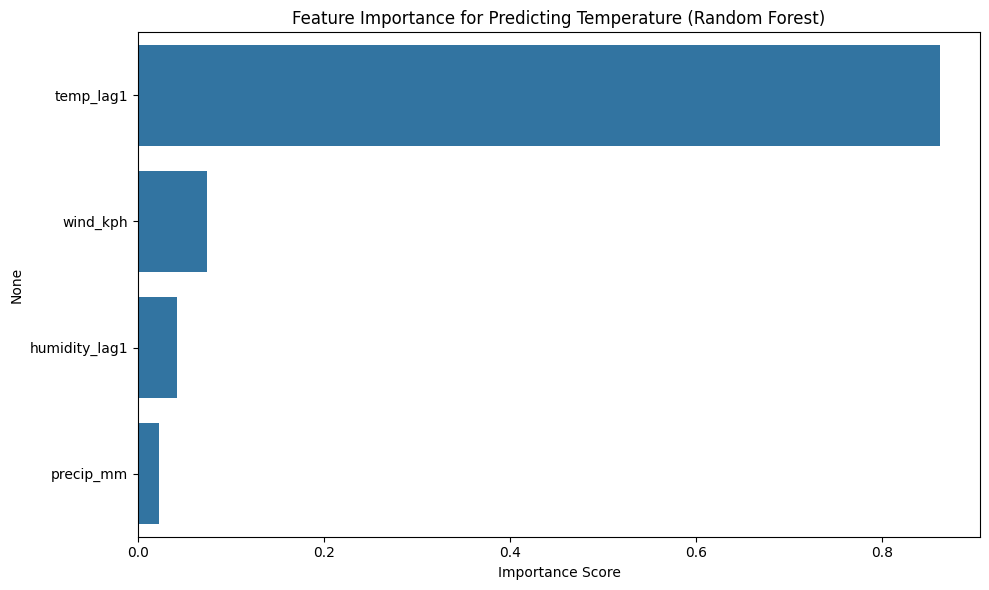

In [9]:
print("--- Assessing Feature Importance ---")
df_supervised = numeric_cols.copy()
df_supervised['temp_lag1'] = df_supervised[TEMP_COL].shift(1)
df_supervised['humidity_lag1'] = df_supervised['humidity'].shift(1)
df_supervised.dropna(inplace=True)

if not df_supervised.empty:
    X = df_supervised[['temp_lag1', 'humidity_lag1', 'wind_kph', 'precip_mm']]
    y = df_supervised[TEMP_COL]

    rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_model.fit(X, y)

    importances = pd.Series(rf_model.feature_importances_, index=X.columns).sort_values(ascending=False)

    plt.figure(figsize=(10, 6))
    sns.barplot(x=importances, y=importances.index)
    plt.title('Feature Importance for Predicting Temperature (Random Forest)')
    plt.xlabel('Importance Score')
    plt.tight_layout()
    plt.savefig('feature_importance.png')
    plt.show()
else:
    print("Not enough data for feature importance analysis.")

## 5. Conclusion

This analysis successfully cleaned and explored the global weather dataset. The ARIMA model provides a solid baseline for temperature forecasting, and advanced techniques revealed key geographical patterns and predictive features. Future work could involve building more complex models (like LSTMs) or analyzing climate change trends over a longer period.